## Final Project Submission

Please fill out:
* Student name: Alex Billinger
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:


## Business Understanding
To improve potable water availability in Tanzania, it is important to have functional water wells. Using the available data, I intend to create a model that can predict which wells require maintenance, and which need to be replaced completely. The model will predict one of three classes: normal functionality, requires maintenance, or completely inoperational.

## CRISP-DM Summary
1. Business Understanding: why do we care about this data?
2. Data Understanding: what data is available, what do the values represent? (Can go back to 1)
3. Data Preparation: cleaning, standardization, etc
4. Modeling: build predictive model (can go back to 3)
5. Evaluation: how well does model predict new data? (can go back to 1)
6. Deployment: present findings, apply model, etc

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
data = pd.read_csv('data/Train_Values.csv')
target = pd.read_csv('data/Train_Labels.csv')
df = pd.concat([data,target['status_group']],axis=1)
to_drop = ['id','num_private','scheme_name','region_code','waterpoint_type_group','source_type','source_class',
          'quantity_group','payment','extraction_type','extraction_type_class','quality_group']
df['date_recorded'] = [int(x.split('-')[0]) for x in df['date_recorded']]
df.drop(to_drop,axis=1,inplace=True)
df[['funder','installer','subvillage','scheme_management']]=df[['funder','installer','subvillage','scheme_management']].fillna('Missing data')
df[['public_meeting','permit']] = df[['public_meeting','permit']].fillna(True).astype('int')
df['district_code'] = df['district_code'].astype('object')
print(df.shape)

data = df.drop(['longitude','latitude'],axis=1)
repl_dict = {'DANID':'DANIDA','World vision':'World Vision','District council':'District Council','Hesawa':'HESAWA',
            'Gove':'Government','Gover':'Government','0':'Missing data'}
data.replace({'installer':repl_dict,'funder':{'0':'Missing data'}},inplace=True)

temp = int(data.loc[data['construction_year']!=0]['construction_year'].median())
data['construction_year'] = data['construction_year'].where(data['construction_year']!=0,temp)

temp = data['subvillage'].value_counts().head(11)
data['subvillage'] = data['subvillage'].where(data['subvillage'].isin(temp.index),'None')
temp = data['wpt_name'].value_counts().head(11)
data['wpt_name'] = data['wpt_name'].where(data['wpt_name'].isin(temp.index),'none')
temp = data['funder'].value_counts().head(45)
data['funder'] = data['funder'].where(data['funder'].isin(temp.index),'None')
temp = data['installer'].value_counts().head(40)
data['installer'] = data['installer'].where(data['installer'].isin(temp.index),'None')
temp = data['ward'].value_counts().head(15)
data['ward'] = data['ward'].where(data['ward'].isin(temp.index),'None')

df.to_csv('data/cleaned.csv',index=False)
print(data.shape)
data.head()

(59400, 29)
(59400, 27)


,amount_tsh,date_recorded,funder,gps_height,installer,wpt_name,basin,subvillage,region,district_code,...,construction_year,extraction_type_group,management,management_group,payment_type,water_quality,quantity,source,waterpoint_type,status_group
0,6000.0,2011,Roman,1390,None,none,Lake Nyasa,None,Iringa,5,...,1999,gravity,vwc,user-group,annually,soft,enough,spring,communal standpipe,functional
1,0.0,2013,None,1399,None,Zahanati,Lake Victoria,None,Mara,2,...,2010,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,2013,None,686,World Vision,none,Pangani,Majengo,Manyara,4,...,2009,gravity,vwc,user-group,per bucket,soft,enough,dam,communal standpipe multiple,functional
3,0.0,2013,Unicef,263,UNICEF,none,Ruvuma / Southern Coast,None,Mtwara,63,...,1986,submersible,vwc,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,0.0,2011,None,0,None,Shuleni,Lake Victoria,None,Kagera,1,...,2000,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


In [39]:
data['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [43]:
temp = df.loc[df['longitude']!=0]
temp['region'].value_counts()

Iringa           5294
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Shinyanga        3977
Arusha           3350
Kagera           3316
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Mwanza           2295
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [7]:
ohe.shape

(59400, 373)

In [42]:
temp = df.loc[df['longitude']==0]
temp['region'].value_counts()

Shinyanga    1005
Mwanza        807
Name: region, dtype: int64

In [124]:
data.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source', 'waterpoint_type', 'status_group'],
      dtype='object')

## Data Cleaning
- remove 'id' before modeling
- drop 'scheme_name': 28166 out of 59400 null
- funder: fill null with 'missing' value, remove missing ohe before modeling (3635)
- installer: same as funder (3655)
- subvillage: same as funder (371)
- public_meeting: (3334) binary value: 91% true, replace NaN as True
- scheme_management: same as funder (3877)
- permit: (3056) binary value: 69% True, what does this represent?
<br>

#### checked for "unusual" values
- num_private: 98.7% = 0, drop column
- amount_tsh: 70.1% = 0, what does this represent?
- gps_height: 34.4% = 0, possibly plausible, but kinda weird, further investigation
- population: 36.0% = 0, odd, maybe turn this into a categorical?
- construction_year: 34.9% = 0, fill with median


#### Other
- checked for "wrong" data types, only date_recorded, which is object (convert to date-time)
- district_code, region_code: categorical?
- wpt_name: many have 'none', remove from ohe
- source has some values "unknown", remove from ohe
- wpt_name: 37400 unique values-maybe take most common 5-10?
- subvillage: 19288 unique values
- ward: 2092 uvs
- installer and funder similar, but uvs in the 1000s, rather than 10000s. Kept 40-45
- for all in too many unique values category, used about 200 entries as cutoff



#### Duplicate information
- region and region_code contain same information, drop one
- waterpoint type and waterpoint type group nearly identical
- source, source type, and source type group contain progressively less info
- quantity and quantity group are identical
- payment and payment_type basically identical
- extraction type (group and class)
- water quality and quality_group

In [14]:
df['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

"Functional needs repair" represents less than 10% of labels, consider over/undersampling

Text(1.7, 1500, '7.27%')

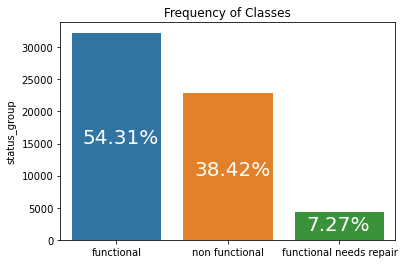

In [32]:
temp = df['status_group'].value_counts()
sns.barplot(temp.index,temp)
plt.title('Frequency of Classes')
font = {'color':  'white',
        'weight': 'normal',
        'size': 20,
        }
temp = df['status_group'].value_counts(normalize=True)
plt.text(-.3,15000,str(round(temp[0]*100,2))+'%',fontdict=font)
plt.text(.7,10000,str(round(temp[1]*100,2))+'%',fontdict=font)
plt.text(1.7,1500,str(round(temp[2]*100,2))+'%',fontdict=font)

In [4]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,30500.000000,2013.000000


In [9]:
col_lst = [x for x in data.columns[:-1] if data[x].dtype=='O']
ohe = pd.get_dummies(data.drop('status_group',axis=1),prefix=col_lst)
to_drop = ['funder_None','funder_Missing data','installer_Missing data','installer_None','wpt_name_none',
           'subvillage_None','ward_None','scheme_management_Missing data','scheme_management_None','management_unknown',
           'management_group_unknown','payment_type_unknown','water_quality_unknown','quantity_unknown','source_unknown']
ohe.drop(to_drop,axis=1,inplace=True)
ohe['year_since_construct'] = ohe['date_recorded']-ohe['construction_year']
ohe.drop(['date_recorded','construction_year'],axis=1,inplace=True)
ohe.head(10)

,amount_tsh,gps_height,population,public_meeting,permit,funder_Adb,funder_Adra,funder_Amref,funder_Ces(gmbh),funder_Danida,...,source_shallow well,source_spring,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,year_since_construct
0,6000.0,1390,109,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,12
1,0.0,1399,280,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
2,25.0,686,250,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
3,0.0,263,58,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,27
4,0.0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11
5,20.0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
6,0.0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
7,0.0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,12
8,0.0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
9,0.0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,11


#### Remove columns that tally missing data or 'none' entries:
- funder_None
- funder_Missing data
- installer_Missing data
- installer_None
- wpt_name_none
- subvillage_None
- ward_None
- scheme_management_Missing data
- scheme_management_None
- management_unknown
- management_group_unknown
- payment_type_unknown
- water_quality_unknown
- quantity_unknown
- source_unknown

In [10]:
ohe.to_csv('data/ohe.csv',index=False)

In [110]:
target['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [111]:
target['translate'] = target['status_group'].map({'functional':0,'functional needs repair':1,'non functional':2})

In [119]:
target.to_csv('data/labels.csv',index=False)